# NIRCam PSF-matched multiband photometry

## Inspecting the results

This is part of a [series of notebooks](https://github.com/dancoe/mirage) simulating and analyzing upcoming JWST NIRCam images in 7 filters: F115W F150W F200W F277W F356W F444W F480M. 

* HST catalog & Sersic fits – (Astropy.photutils, Astropy.modeling)
* NIRCam predicted fluxes in each filter – (BAGPIPES)
* NIRCam simulated image – (MIRAGE)
* Images processed & combined – (JWST Pipeline; CEERS tips & scripts)
* Object Detections & PSF-matched photometry – (Astropy.photutils)
* **Photometry results inspection (this notebook)**
* Photometric redshifts & SED fitting – (BAGPIPES)

These tools are meant for general use analyzing galaxies observed with JWST NIRCam. Here we've simulated observations upcoming in JWST GO 1433 (PI Coe) of the galaxy cluster MACS0647+70 and the triply-lensed z=11 candidate MACS0647-JD.

The simulated images *_i2d.fits are available here:
https://stsci.app.box.com/v/coe-nircam-mirage/folder/161595382965  
Unfortunately, there are currently slight misalignments between the short (< 2.4µm) and long (> 2.4 µm) wavelength images.

This simulation of a galaxy cluster is meant to complement existing simulations of blank fields:
* JADES: https://fenrir.as.arizona.edu/jaguar/
* CEERS: https://ceers.github.io/releases.html

An older version of this notebook (analyzing JADES simulated data) is available in STScI's JWST Data Analysis Tools (JDAT):  
https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam_PSF-matched_photometry/NIRCam_PSF_matched_multiband_photometry.html

https://github.com/dancoe/mirage  
https://dancoe.space/jwst/simulations

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits, ascii
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

import photutils
print('photutils', photutils.__version__)
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog#, source_properties
from photutils.utils import calc_total_error

from photutils.psf.matching import resize_psf, create_matching_kernel, CosineBellWindow
from astropy.convolution import convolve, convolve_fft # , Gaussian2DKernel, Tophat2DKernel

photutils 1.4.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.0.1

photutils : 1.4.0
watermark : 2.3.1
matplotlib: 3.5.1
astropy   : 5.0.4
numpy     : 1.22.4



## Load catalog and segmentation map

In [4]:
# Catalog: ecsv format preserves units for loading in Python notebooks
field = 'MACS0647'
output_catalog = QTable.read(field+'_photometry.ecsv')

In [5]:
# Reconstitute filter list
filters = []
for param in output_catalog.columns:
    if param[-4:] == '_mag':
        filters.append(param[:-4])

In [6]:
# Segmentation map
segmfile = field+'_detections_segm.fits'
segm = fits.open(segmfile)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

# Input simulation catalog

In [7]:
#input_catalog_file = os.path.join(home, 'm0647', 'Ryan', field+'.ecsv')
input_catalog_file = 'MACS0647_NIRCam_input_catalog.cat'
simulated_catalog = ascii.read(input_catalog_file)
# catalog has magnitudes; add units to them and add fluxes
for filt in filters:
    mag = simulated_catalog[filt+'_mag'] * u.ABmag
    simulated_catalog[filt+'_flux'] = mag.to(u.nJy)
    
#simulated_catalog

### Match objects to photutils catalog

https://docs.astropy.org/en/stable/coordinates/matchsep.html

In [8]:
input_coordinates = SkyCoord(ra=simulated_catalog['RA']*u.deg, dec=simulated_catalog['Dec']*u.deg)
# Can use output_catalog['sky_centroid'] if saved in table, but this demo saved (ra,dec) instead:
detected_coordinates = SkyCoord(ra=output_catalog['ra'], dec=output_catalog['dec'])
# Match photutils detection sources to input object catalog:
input_match_indices, separation2d, distance3d = detected_coordinates.match_to_catalog_sky(input_coordinates)

Determine threshold maximum distance between input objects and matched output sources

<IPython.core.display.Javascript object>


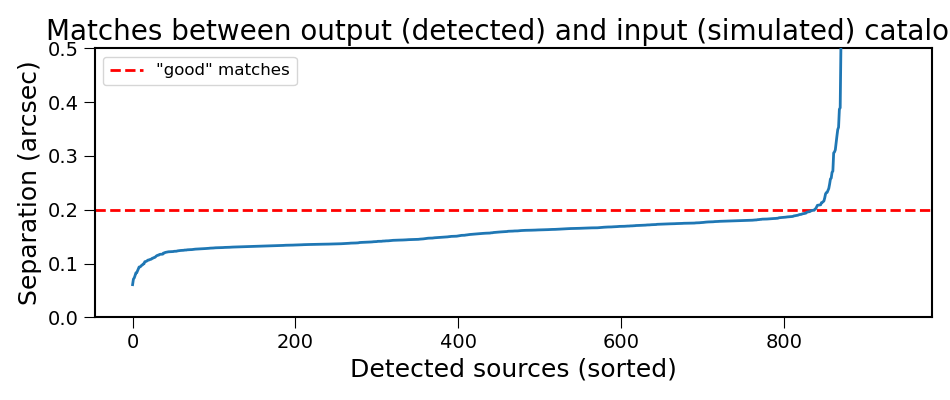

(0.0, 0.5)

In [9]:
# Determine threshold maximum distance between input objects and matched output sources
fig = plt.figure(figsize=(9.5, 4))
plt.rc('font', size=12)   
plt.plot(np.sort(separation2d.to(u.arcsec)), zorder=10)
#separation_max = 0.036 * u.arcsec  # determined by eye after plotting
separation_max = 0.2 * u.arcsec  # determined by eye after plotting
plt.axhline(0, c='k', ls=':')
plt.axhline(separation_max.value, c='r', ls='--', label='"good" matches')
plt.title('Matches between output (detected) and input (simulated) catalogs')
plt.xlabel('Detected sources (sorted)')
plt.ylabel('Separation (arcsec)')
plt.legend()
plt.ylim(0,0.5)

In [10]:
good_matches = separation2d < separation_max
unique_matches, index_counts = np.unique(input_match_indices[good_matches], return_counts=True)

print('%d matches (%d unique) between input catalog (%d galaxies) and photutils catalog (%d detected sources)'
      % (np.sum(good_matches), len(unique_matches), len(simulated_catalog), len(output_catalog)))

multiple_matches = unique_matches[index_counts > 1]
if len(multiple_matches):
    print('Input sources matched multiple times:', list(output_catalog['id'][multiple_matches]))

# Only keep close matches
simulated_catalog_matched = simulated_catalog[input_match_indices][good_matches]
output_catalog_matched = output_catalog[good_matches]

838 matches (836 unique) between input catalog (1006 galaxies) and photutils catalog (936 detected sources)
Input sources matched multiple times: [257, 353]


# Look at detections

In [11]:
image_files_list = glob('images/*_i2d.fits')
image_files_list = list(np.sort(image_files_list))
filters = [image_file.split('_')[1] for image_file in image_files_list]
image_files = {}
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns
for i, filt in enumerate(filters):
    image_files[filt] = image_files_list[i]

detection_filter = filt = 'F200W'
infile = image_files[filt]
hdu = fits.open(infile)
data = hdu[1].data
imwcs = wcs.WCS(hdu[1].header, hdu)

# Make color image (Lupton method: saturated objects have color, not white)
r = fits.open(image_files['F444W'])[1].data
g = fits.open(image_files['F200W'])[1].data
b = fits.open(image_files['F115W'])[1].data
color_image = make_lupton_rgb(r, g, b, Q=5, stretch=0.02) # , minimum=-0.001

<IPython.core.display.Javascript object>


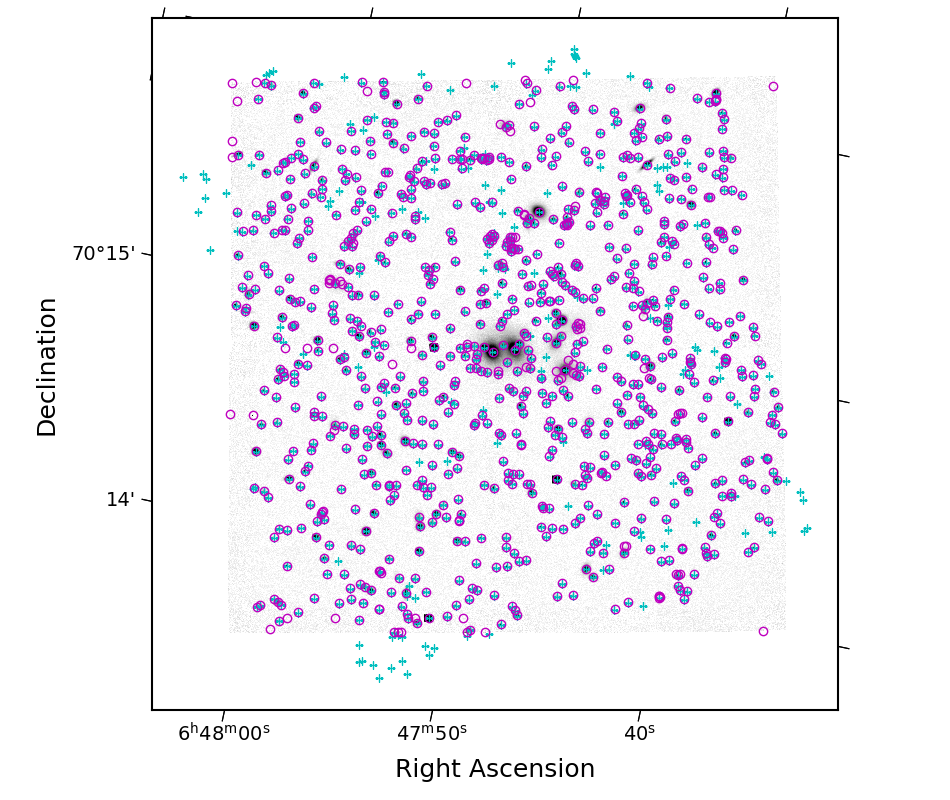

In [12]:
fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(simulated_catalog['RA']*u.deg, simulated_catalog['Dec']*u.deg,
         'c+', mfc='None', transform=ax.get_transform('world'))
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

<IPython.core.display.Javascript object>


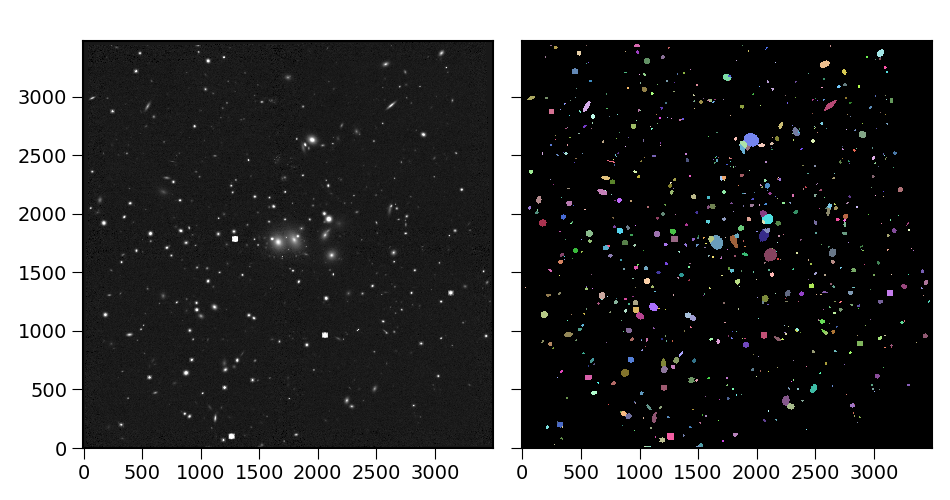

Pan / zoom with controls. Hover cursor over segmentation map to read output id in [brackets].


In [13]:
# Show image and segmentation map detections in synced plots
data = fits.open(image_files['F200W'])[1].data

fig, ax = plt.subplots(1, 2, figsize=(9.5,5), sharex=True, sharey=True)

norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )

cmap = segm.make_cmap(seed=123)
ax[1].imshow(segm, origin='lower', interpolation='none', cmap=cmap)

print('Pan / zoom with controls. Hover cursor over segmentation map to read output id in [brackets].')

In [14]:
# Look at one object with output_id from segmentation map
output_id = 400
matched_index = list(output_catalog_matched['id']).index(output_id)
input_obj = simulated_catalog_matched[matched_index]
output_obj = output_catalog_matched[matched_index]
segm_obj = segm.segments[segm.get_index(output_id)]
output_obj

id,xcentroid,ycentroid,ra,dec,area,a,b,ellipticity,orientation,gini,kron_radius,local_background,total_flux_cor,F115W_flux,F115W_fluxerr,F115W_mag,F115W_magerr,F150W_flux,F150W_fluxerr,F150W_mag,F150W_magerr,F200W_flux,F200W_fluxerr,F200W_mag,F200W_magerr,F277W_flux,F277W_fluxerr,F277W_mag,F277W_magerr,F356W_flux,F356W_fluxerr,F356W_mag,F356W_magerr,F444W_flux,F444W_fluxerr,F444W_mag,F444W_magerr,F480M_flux,F480M_fluxerr,F480M_mag,F480M_magerr,F277W_PSF_flux_cor,F356W_PSF_flux_cor,F444W_PSF_flux_cor,F480M_PSF_flux_cor
,,,deg,deg,pix2,pix,pix,,deg,,pix,,,nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64
400,1863.5129,1873.0844,101.9556820,70.2500320,2090,11.0441,8.8822,0.1957,31.4764,0.4725,2.3013,0.0002,1.5608,12631.2760,85.1578,21.1464,0.0073,17282.6937,77.4122,20.8060,0.0049,15593.2267,44.9092,20.9177,0.0031,13510.3824,18.9240,21.073330898020487,0.0015197297889844833,14748.6118,18.6552,20.97812213920641,0.0013724528500741082,19086.5888,23.6834,20.698179204804767,0.0013463870555577198,11231.5906,64.2998,21.273896834947106,0.0061980083304600895,1.0015,1.0018,1.0029,1.0028


In [15]:
# Alternartively, could select an object by position
# x, y = 905, 276
# output_id = segm.data[y,x]

## Show selected object in all filters

<IPython.core.display.Javascript object>


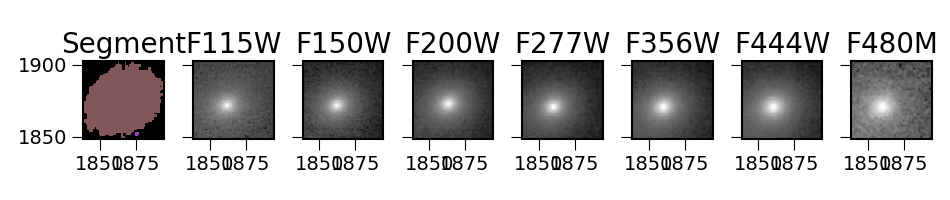

In [16]:
fig, ax = plt.subplots(1, len(filters)+1, figsize=(9.5, 2), sharex=True, sharey=True)

#cmap = segm.make_cmap(seed=123)  # already made above
ax[0].imshow(segm.data[segm_obj.slices], origin='lower', extent=segm_obj.bbox.extent, cmap=cmap,
             interpolation='nearest')
ax[0].set_title('Segment')

for i in range(1, len(filters)+1):
    filt = filters[i-1]

    # Show data on top row
    data = fits.open(image_files[filt])[1].data  # 'SCI'
    stamp = data[segm_obj.slices]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each filter individually
    ax[i].imshow(stamp, extent=segm_obj.bbox.extent, cmap='Greys_r', norm=norm, origin='lower')
    ax[i].set_title(filt.upper())

# Plot Spectral Energy Distribution (SED) for one object

In [17]:
# automatic secondary axis magnitudes don't work when fluxes extend to negative values
# so I wrote my own code to do this

def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    return f.value

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    return m.value

def add_magnitude_axis(ax, flux_units=u.nJy, plothuge=True):
    ylo, yhi = plt.ylim() * flux_units
    maghi = yhi.to(u.ABmag).value
    ytx1 = np.ceil(maghi * 10) / 10.  # 24.101 -> 24.2
    ytx2 = np.ceil(maghi)  # 24.1 -> 25

    fpart = ytx1 - int(ytx1)  # 0.2
    if np.isclose(fpart, 0) or np.isclose(fpart, 0.9):
        ytx1 = []
    elif np.isclose(fpart, 0.1) or np.isclose(fpart, 0.2):
        ytx1 = np.array([ytx1, ytx2-0.7, ytx2-0.5, ytx2-0.3])  # 24.1, 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.3) or np.isclose(fpart, 0.4):
        ytx1 = np.array([ytx1, ytx2-0.5, ytx2-0.3])  # 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.5):
        ytx1 = np.array([ytx1, ytx2-0.3])  # 24.5, 24.7
    elif np.isclose(fpart, 0.6):
        ytx1 = np.array([ytx1, ytx2-0.2])  # 24.6, 24.8

    if isinstance(ytx1, float):
        ytx1 = np.array([ytx1])

    if plothuge:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 2])
    else:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 1.5, 2, 3])

    ytx2 = np.array([ytx2])
    ytx = np.concatenate([ytx1, ytx3])
    yts = ['%g' % mag for mag in ytx]

    ytx = (ytx * u.ABmag).to(flux_units).value
    
    ax2 = ax.twinx()
    ax.yaxis.set_label_position('left')
    ax2.yaxis.set_label_position('right')
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    ax2.set_yticks(ytx)
    ax2.set_yticklabels(yts)
    ax2.set_ylabel('Magnitude (AB)')
    ax2.set_ylim(ylo.value, yhi.value)
    ax2.set_zorder(-100)  # interactive cursor will output left axis ax

In [18]:
#input_mags = np.array([input_obj[filt+'_mag'] for filt in filters])
#input_fluxes = np.array([(mag*u.ABmag).to(u.nJy).value for mag in input_mags])
input_fluxes  = np.array([input_obj[filt+'_flux'] for filt in filters])
output_fluxes = np.array([output_obj[filt+'_flux'].value for filt in filters])
output_flux_errs = np.array([output_obj[filt+'_fluxerr'].value for filt in filters])

In [19]:
PSF_flux_corrections = np.ones(len(filters))
for i, filt in enumerate(filters):
    PSFcor_column = filt+'_PSF_flux_cor'
    if PSFcor_column in list(output_obj.columns):
        PSF_flux_corrections[i] = output_obj[PSFcor_column]

PSF_flux_corrections

array([1.        , 1.        , 1.        , 1.00152292, 1.00179162,
       1.00285245, 1.00277351])

In [20]:
# Measured flux does not recover total input flux
# Given known simulation input, determine what fraction of the flux was recovered
# Use this to scale measured SED to input SED for comparison, plotted below

# Scale output to input flux using F200W only (other filters may have incorrect flux corrections)

filt = 'F200W'
flux_scale_factor = output_obj[filt+'_flux'].value / input_obj[filt+'_flux']
flux_factor = 1 / flux_scale_factor  # input / output
print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

116% of input flux recovered by photutils


In [21]:
if 0:
    # Scale output to input flux considering all measured fluxes and uncertainties
    # Benitez+00 Equations 8 & 9
    FOT = np.sum(input_fluxes * output_fluxes / output_flux_errs**2)
    FTT = np.sum(input_fluxes**2 / output_flux_errs**2)
    flux_scale_factor = FOT / FTT  # a_m: observed / theoretical (output / input)
    flux_factor = 1 / flux_scale_factor  # input / output
    print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

<IPython.core.display.Javascript object>


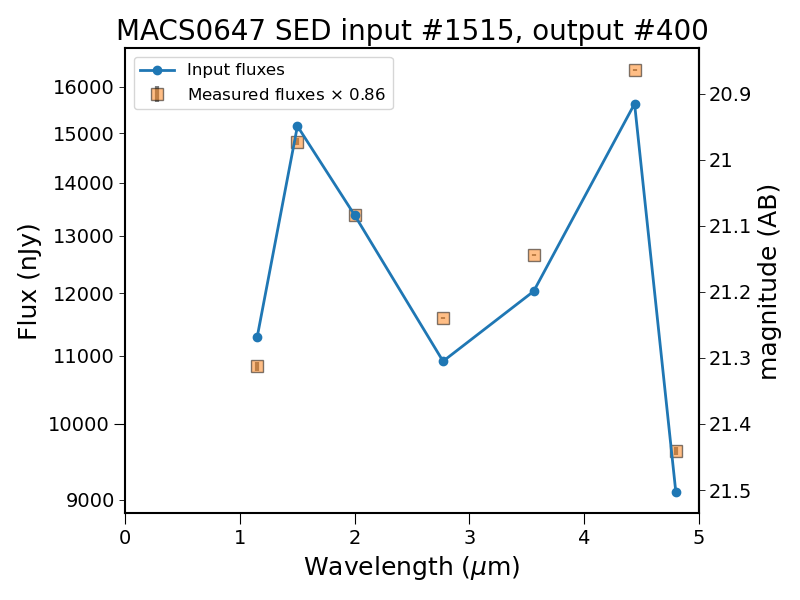

Text(0.5, 1.0, 'MACS0647 SED input #1515, output #400')

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(wavelengths, input_fluxes, 'o-', label='Input fluxes', zorder=10, scaley=False)

label = 'Measured fluxes $\\times$ %.2f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc=mpl_colors[1], c='k', lw=3, alpha=0.5, ls='none', label=label)

if 0:
    label = 'Measured fluxes before PSF corrections $\\times$ %.2f' % flux_factor
    plt.errorbar(wavelengths.value, output_fluxes * flux_factor / PSF_flux_corrections, output_flux_errs * flux_factor,
                 ms=8, marker='s', mfc='r', c='k', lw=3, alpha=0.5, ls='none', label=label, zorder=-10)

plt.legend()
plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
#plt.ylim(15, 70)
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('Flux (nJy)')
plt.semilogy()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

# Add AB magnitudes as secondary x-axis at right
# (Note this breaks if any fluxes are negative)
# https://matplotlib.org/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py

# secondary_axis = add_magnitude_axis(ax, flux_units)
secax = ax.secondary_yaxis('right', functions=(nJy2AB, AB2nJy))
secax.set_ylabel('magnitude (AB)')
secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
secax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

plt.title(field + ' SED input #%d, output #%d' % (input_obj['id'], output_obj['id']))
# plt.savefig(field + '_SED_input%d_output%d.png' % (input_obj['id'], output_obj['id']))

# Plots

<IPython.core.display.Javascript object>


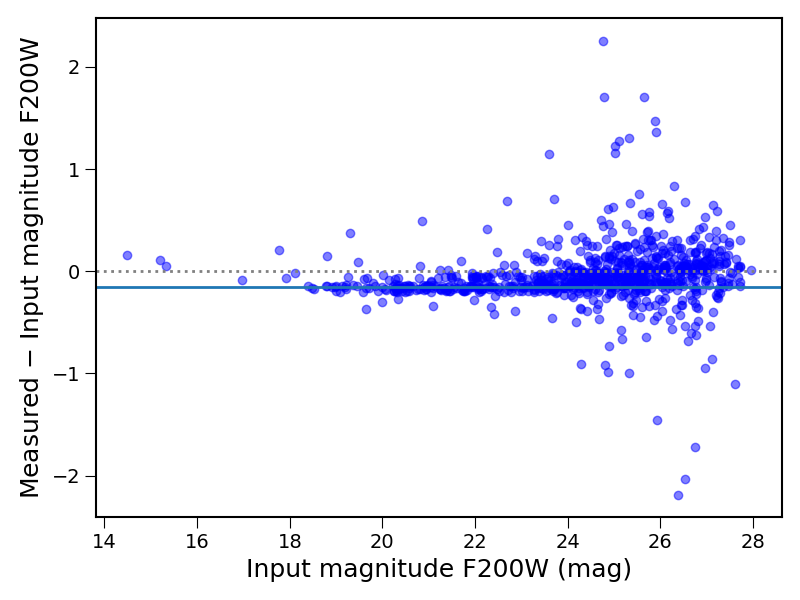

Text(0, 0.5, 'Measured $-$ Input magnitude F200W')

In [23]:
# Input vs. Output Magnitude

filt = 'F200W'
input_mag  = simulated_catalog_matched[filt + '_mag'].value
output_mag = output_catalog_matched[filt + '_mag'].value

# Only plot detections
det_input  = (0 < input_mag)  & (input_mag  < 90)
det_output = (0 < output_mag) & (output_mag < 90)
det = det_input * det_output

input_mag = input_mag[det]
output_mag = output_mag[det]

plt.figure(figsize=(8, 6))

plt.plot(input_mag, output_mag - input_mag, 'bo', alpha=0.5)

plt.axhline(-0.15)
plt.axhline(0, ls=':', c='0.50')
plt.xlabel('Input magnitude ' + filt + ' (mag)')
plt.ylabel('Measured $-$ Input magnitude %s' % filt)

In [24]:
def between(lo, x, hi):
    return (lo < x) & (x < hi)

<IPython.core.display.Javascript object>


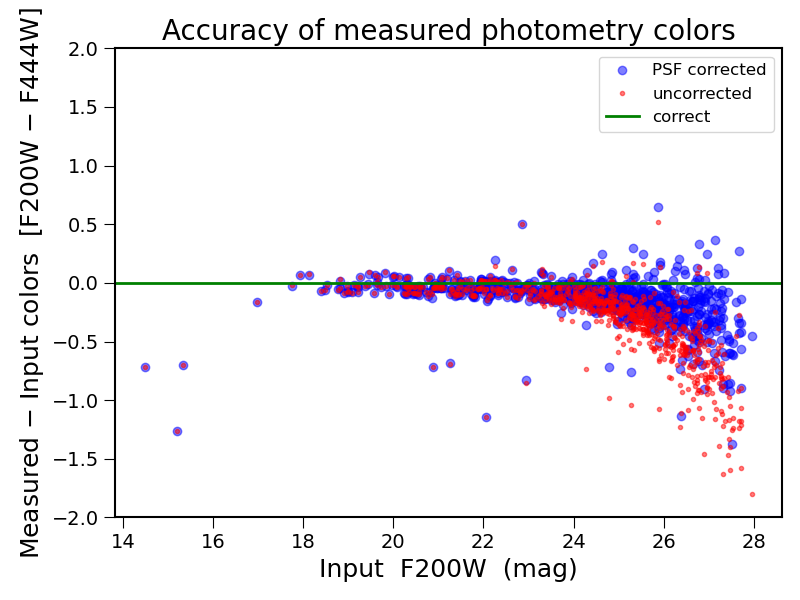

In [25]:
# Input vs. Output Color

#filt1, filt2 = 'F115W F200W'.split()
filt1, filt2 = 'F200W F444W'.split()

input_flux1 = simulated_catalog_matched[filt1 + '_mag']
input_flux2 = simulated_catalog_matched[filt2 + '_mag']

input_mag1 = input_flux1 
input_mag2 = input_flux2

output_mag1 = output_catalog_matched[filt1 + '_mag'].value
output_mag2 = output_catalog_matched[filt2 + '_mag'].value
#output_ids  = output_catalog_matched['id'].data.astype(int)

# Only plot detections
det1 = between(0, output_mag1, 90)
det2 = between(0, output_mag2, 90)
input_det1 = between(0, input_mag1, 90)
input_det2 = between(0, input_mag2, 90)
det = det1 * det2 * input_det1 * input_det2

input_mag1 = input_mag1[det]
input_mag2 = input_mag2[det]

output_mag1 = output_mag1[det]
output_mag2 = output_mag2[det]

input_color  = input_mag1 - input_mag2
output_color = output_mag1 - output_mag2

output_mag1_uncor = output_mag1
PSF_flux_cor = output_catalog[filt2+'_PSF_flux_cor']
PSF_mag_cor = -2.5 * np.log10(PSF_flux_cor)
output_mag2_uncor = output_mag2 - PSF_mag_cor[good_matches][det].value
output_color_uncor = output_mag1_uncor - output_mag2_uncor

plt.figure(figsize=(8, 6))

plt.plot(input_mag1, output_color - input_color, 'bo', alpha=0.5, label='PSF corrected')
plt.plot(input_mag1, output_color_uncor - input_color, 'r.', alpha=0.5, label='uncorrected')

plt.axhline(0, c='g', label='correct')
plt.xlabel('Input  ' + filt1 + '  (mag)')
plt.ylabel('Measured $-$ Input colors  [%s $-$ %s]' % (filt1, filt2))
#plt.ylim(-5,5)
plt.ylim(-2,2)
plt.title('Accuracy of measured photometry colors')

plt.legend();
# plt.savefig(field+'_color_deviation_%s-%s.png' % (filt1, filt2))

## Plot magnitudes and look for dropouts

<IPython.core.display.Javascript object>


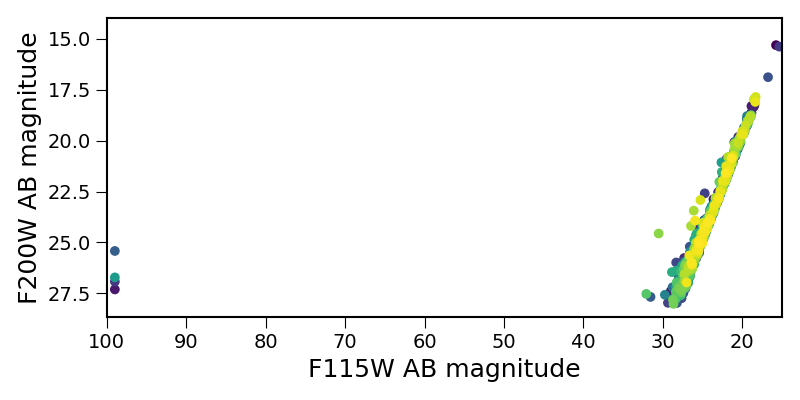

(28.67981798257976, 13.984928416775098)

In [26]:
filt1, filt2 = 'F115W F200W'.split()

mag1 = output_catalog_matched[filt1+'_mag']
mag2 = output_catalog_matched[filt2+'_mag']

# Only plot detections in F200W
det2 = (0*u.ABmag < mag2) & (mag2 < 90*u.ABmag)

mag1 = mag1[det2]
mag2 = mag2[det2]
ids = output_catalog_matched['id'][det2].data.astype(int)

plt.figure(figsize=(8,4))

plt.scatter(mag1, mag2, c=ids)

plt.xlabel(filt1+' AB magnitude')
plt.ylabel(filt2+' AB magnitude')

plt.xlim(plt.xlim(15,100)[::-1])  # brighter at right
plt.ylim(plt.ylim()[::-1])  # brighter at top

#mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
#print('Hover cursor over data point to reveal magnitudes and catalog ID number')

In [27]:
# Select brightest dropout not detected in F115W (mag = 99)
dropouts = output_catalog['F115W_mag'] > 90 * u.ABmag 
i_brightest_dropout = output_catalog[dropouts]['F200W_mag'].argmin()
output_id = output_catalog[dropouts][i_brightest_dropout]['id']
output_id

279

In [28]:
dropouts = output_catalog_matched['F115W_mag'] > 90 * u.ABmag 
dropouts_catalog = output_catalog_matched[dropouts]
dropouts_catalog.sort('F200W_mag')
dropouts_catalog

id,xcentroid,ycentroid,ra,dec,area,a,b,ellipticity,orientation,gini,kron_radius,local_background,total_flux_cor,F115W_flux,F115W_fluxerr,F115W_mag,F115W_magerr,F150W_flux,F150W_fluxerr,F150W_mag,F150W_magerr,F200W_flux,F200W_fluxerr,F200W_mag,F200W_magerr,F277W_flux,F277W_fluxerr,F277W_mag,F277W_magerr,F356W_flux,F356W_fluxerr,F356W_mag,F356W_magerr,F444W_flux,F444W_fluxerr,F444W_mag,F444W_magerr,F480M_flux,F480M_fluxerr,F480M_mag,F480M_magerr,F277W_PSF_flux_cor,F356W_PSF_flux_cor,F444W_PSF_flux_cor,F480M_PSF_flux_cor
,,,deg,deg,pix2,pix,pix,,deg,,pix,,,nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),nJy,nJy,mag(AB),mag(AB),,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64
279,947.7331,1447.8973,101.9822478,70.2433058,104,2.5568,2.4848,0.0281,12.3593,0.2903,2.1769,-0.0002,1.6196,-5.6910,12.1356,99.0000,29.2134,153.1374,10.2320,25.9373,0.0702,247.4197,6.1936,25.4164,0.0268,235.0321,3.9198,25.472182197743688,0.01795841128398738,233.8303,3.7810,25.47774813876925,0.017415860308834973,256.4781,5.1169,25.3773744354979,0.021448080496750947,302.5689,15.9978,25.197939169033546,0.05594032045735815,1.0916,1.1038,1.1193,1.1286
513,2547.0370,2304.6829,101.9366173,70.2562920,43,2.3151,1.4404,0.3778,-89.5035,0.1486,2.1697,-0.0001,1.9723,-1.0325,8.5530,99.0000,29.8071,38.6192,7.2770,27.4330,0.1874,74.9924,4.3173,26.7125,0.0608,64.7405,3.5436,26.872059992885767,0.057858361925988436,104.9327,3.4591,26.347722634670497,0.03521410872500576,154.5167,4.8644,25.927561515968605,0.033653211096561095,123.5367,14.9930,26.170509662984408,0.124367520950966,1.3167,1.3385,1.3640,1.3810
156,3275.0011,930.8867,101.9038894,70.2430212,34,1.8546,1.2220,0.3411,-80.2234,0.2228,1.5027,0.0000,1.2904,-3.6017,5.5392,99.0000,29.8182,22.1181,4.6677,28.0381,0.2079,62.0094,2.8043,26.9189,0.0480,79.7973,2.3393,26.64502964363063,0.03137196659691018,137.4687,2.4173,26.054490683609135,0.018926108358862357,251.6634,3.4457,25.397950024390678,0.014764925227607601,239.4103,10.1848,25.452142901305592,0.045233205612141704,1.5338,1.5682,1.6103,1.6386
65,2766.3959,456.4048,101.9170369,70.2366988,13,1.0660,0.8973,0.1582,46.2475,0.1574,3.2175,0.0000,4.3528,-0.8695,11.3939,99.0000,30.3552,32.8479,9.3072,27.6087,0.2709,43.4914,5.5335,27.3040,0.1300,34.4398,4.2921,27.557347713882322,0.1275206642735468,70.4862,4.3319,26.77973967556586,0.06475675173025387,144.9337,6.1755,25.99707634413352,0.04530364380476991,59.4654,18.5458,26.964338996942395,0.2947318092383308,1.3451,1.3736,1.4050,1.4266


In [29]:
# ...or 2nd brightest dropout
output_id = dropouts_catalog[1]['id']
output_id

513

<IPython.core.display.Javascript object>


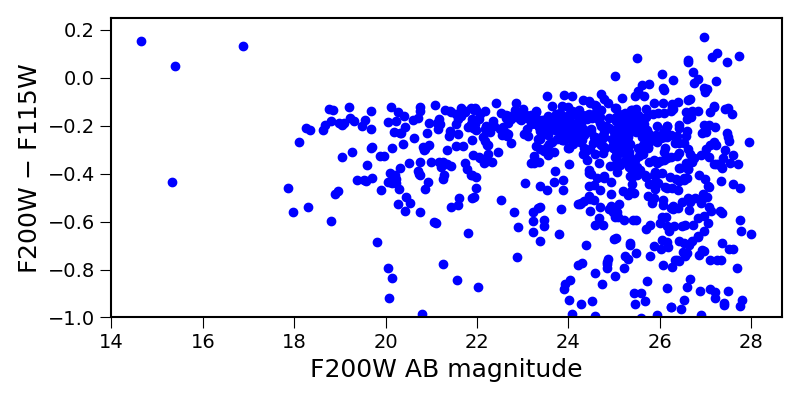

(-1.0, 0.25)

In [30]:
# Color vs. magnitude

#filt1, filt2 = 'F200W F444W'.split()
filt1, filt2 = 'F115W F200W'.split()
mag1 = output_catalog_matched[filt1+'_mag'].value
mag2 = output_catalog_matched[filt2+'_mag'].value

# Only plot detections
det1 = between(0, mag1, 90)
det2 = between(0, mag2, 90)
det = det1 * det2

mag1 = mag1[det]
mag2 = mag2[det]

plt.figure(figsize=(8,4))

plt.plot(mag2, mag2 - mag1, 'bo')
plt.xlabel(filt2+' AB magnitude')
plt.ylabel('%s $-$ %s' % (filt2, filt1))

plt.ylim(-1, 0.25)